In [ ]:
# Example of a Gaussian Process Regression with multiple local minima
# in the marginal log-likelihood as a function of the hyperparameters
# Based on: https://github.com/probml/pmtk3/blob/master/demos/gprDemoMarglik.m
# Authors: Drishti Patel & Gerardo Durán-Martín

#import superimport

import numpy as np
import matplotlib.pyplot as plt
import pyprobml_utils as pml
from numpy.linalg import inv, slogdet
from scipy.optimize import minimize


#via gp_predictive_post to get the prediction value and plot also the uncertian area
def plot_gp_pred(x, y, xstar, k, sigma_f, l, sigma_y, ax):
    ystar, Sigma_post = gp_predictive_post(xstar, x, y, k, sigma_y, sigma_f, l)
    upper_bound = ystar.ravel() + 2 * np.sqrt(np.diag(Sigma_post))
    lower_bound = ystar.ravel() - 2 * np.sqrt(np.diag(Sigma_post))
    ax.scatter(x, y, marker="+", s=100, c="black")
    ax.plot(xstar, ystar, c="black")
    ax.fill_between(xstar.ravel(), lower_bound, upper_bound, color="tab:gray", alpha=0.3, edgecolor="none")
    ax.set_xlim(-7.5, 7.5)
    ax.set_ylim(-2, 2.5)
    
def plot_marginal_likelihood_surface(x, y, sigma_f, l_space, sigma_y_space, ax, levels=None):
    P = np.stack(np.meshgrid(l_space, sigma_y_space), axis=0)
    Z = np.apply_along_axis(lambda p: log_likelihood(x, y, sigma_f, *p), 0, P)
    ax.contour(*np.exp(P), Z, levels=levels)
    ax.set_xlabel("characteristic length scale")
    ax.set_ylabel("noise standard deviation")
    ax.set_xscale("log")
    ax.set_yscale("log")


$$
\begin{aligned}
\log p(\mathbf{y} \mid \mathbf{X})=\log \mathcal{N}\left(\mathbf{y} \mid \mathbf{0}, \mathbf{K}_y\right) &=-\frac{1}{2} \mathbf{y} \mathbf{K}_y^{-1} \mathbf{y}-\frac{1}{2} \log \left|\mathbf{K}_y\right|-\frac{N}{2} \log (2 \pi) \\
\frac{\partial}{\partial \theta_j} \log p(\mathbf{y} \mid \mathbf{X}) &=\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \frac{\partial \mathbf{K}_y}{\partial \theta_j} \mathbf{K}_y^{-1} \mathbf{y}-\frac{1}{2} \operatorname{tr}\left(\mathbf{K}_y^{-1} \frac{\partial \mathbf{K}_y}{\partial \theta_j}\right) \\
& = \frac{1}{2} \operatorname{tr}\left(\left(\boldsymbol{\alpha} \boldsymbol{\alpha}^T-\mathbf{K}_y^{-1}\right) \frac{\partial \mathbf{K}_y}{\partial \theta_j}\right)
\end{aligned}
$$

we can define $θ = log(σ^2_y)$, $θ = log(\ell)$and then use the chain rule. 

In [8]:
def log_likelihood(x, y, sigma_f, l, sigma_y):
    """
    Compute marginal log-likelihood of a regression GP
    with rbf kernel

    Parameters
    ----------
    x: array(n, 1)
        Training independent variables
    y: array(n, 1)
        Training dependent variables
    sigma_f: float
        Vertical-scale parameter
    l: float
        Horizontal-scale parameter
    sigma_y: float
        data noise
    
    Returns
    -------
    * float:
        Marginal log-likelihood as the specified hyperparameters
    """
    n, _ = x.shape
    
    # first put l to scale the x value and using logl as input here using exp(l) to change back 
    x = x / np.exp(l)
    #get convarince of the x + noise
    Kxx = k(x, x.T, sigma_f) + np.exp(2 * sigma_y) * np.eye(n)
    #计算数组行列式的符号和（自然）对数， DKxx=行列式绝对值的自然对数
    _, DKxx = slogdet(Kxx)
    l = -1/2 * (y.T @ inv(Kxx) @ y + DKxx + n * np.log(2 * np.pi))
    return l.item()

In [ ]:
#kernal function
def k(u, v, sigma_f, l=1):
    return sigma_f ** 2 * np.exp(-(u - v) ** 2 / (2 * l ** 2))

#predict post
def gp_predictive_post(xstar, x, y, k, sigma_y, *args, **kwargs):
    """
    Compute predictive distribution of a 1D-Gaussian Process for
    regression

    Parameters
    ----------
    xstar: array(nt, 1)
        Values to perform inference on
    x: array(n, 1)
        Training independent variables
    y: array(n, 1)
        Training dependent variables
    k: function
        Kernel function to evaluate the GP
    sigma_y: float
        data-noise term
    *args: additional arguments of k
    **kwargs: additional keyword-arguments of k

    Returns
    -------
    * array(nt, 1):
        Array of predicted (mean) values
    * array(nt, nt):
        Posterior covariance matrix
    """
    n, _ = x.shape
    kstar = k(x, xstar.T, *args, **kwargs)
    Kxx = k(x, x.T, *args) + sigma_y ** 2 * np.eye(n)
    kxx_star = k(xstar, xstar.T, *args, **kwargs)
    Kxx_inv = inv(Kxx)
    ystar = kstar.T @ Kxx_inv @ y
    Sigma_post = kxx_star - kstar.T @ Kxx_inv @ kstar
    
    return ystar, Sigma_post

In [9]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
sigma_f=1.0
x = np.array([-1.3089, 6.7612, 1.0553, -1.1734, -2.9339, 7.2530, -6.5843])[:, None]
y = np.array([1.6218, 1.8558, 0.4102, 1.2526, -0.0133, 1.6380, 0.2189])[:, None]
xstar = np.linspace(-7.5, 7.5, 201)

ngrid = 41
l_space = np.linspace(np.log(0.5), np.log(80), ngrid)
sigma_y_space = np.linspace(np.log(0.03), np.log(3), ngrid)
P = np.stack(np.meshgrid(l_space, sigma_y_space), axis=0)
configs = [(1.0, 0.2), (10, 0.8)]

In [13]:
xstar.shape

(201,)

saving image to /home/jupyter/src/General ML/../figures/gpr_config0.pdf


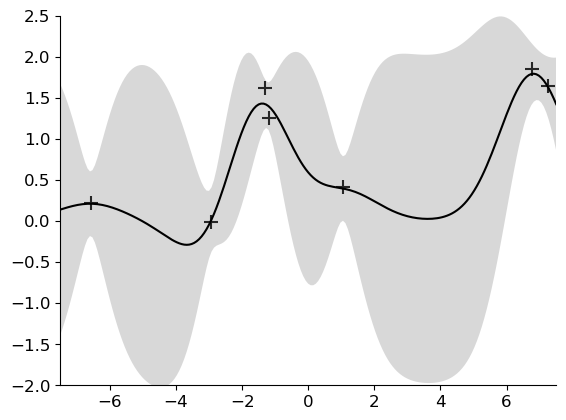

In [11]:
#using configs[0] sigma_y=1.0, \ell = 0.2 to plot the gp figure 
fig, ax = plt.subplots()
plot_gp_pred(x, y, xstar, k, sigma_f, *configs[0], ax)
pml.savefig("gpr_config0.pdf")

saving image to /home/jupyter/src/General ML/../figures/gpr_config1.pdf


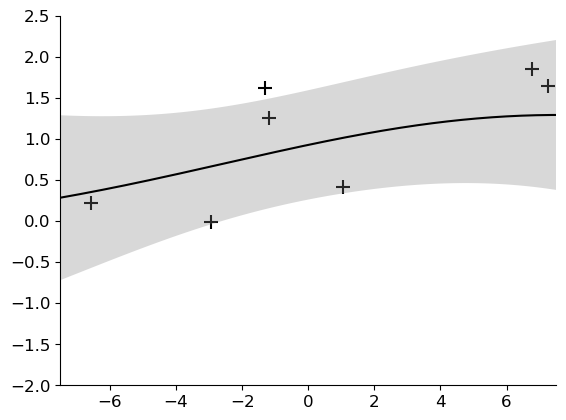

In [10]:
#using configs[1] sigma_y=10, \ell=0.8  to plot the gp figure 
fig, ax = plt.subplots()
plot_gp_pred(x, y, xstar, k, sigma_f, *configs[1], ax)
pml.savefig("gpr_config1.pdf")

saving image to /home/jupyter/src/General ML/../figures/gpr_marginal_likelihood.pdf
[1.30959165 0.24012639]
[12.58104604  0.61357821]


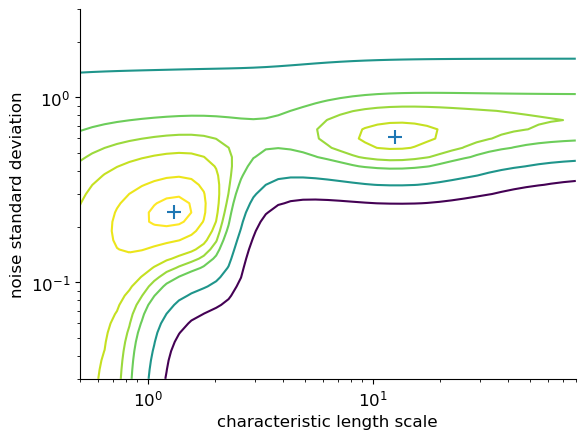

In [38]:
#using maximum likelihood = minimize -ll, to search the sigma_f and \ell
ngrid = 41
w01 = np.array([np.log(1), np.log(0.1)])  #guess 1 :sigma_y=1, \ell=0.1
w02 = np.array([np.log(10), np.log(0.8)]) #guess 2 :sigma_y=10, \ell=0.8
s0 = minimize(lambda p: -log_likelihood(x, y, sigma_f, *p), w01)
s1 = minimize(lambda p: -log_likelihood(x, y, sigma_f, *p), w02)
levels = -np.array([8.3, 8.5, 8.9, 9.3, 9.8, 11.5, 15])[::-1]
l_space = np.linspace(np.log(0.5), np.log(80), ngrid)
sigma_y_space = np.linspace(np.log(0.03), np.log(3), ngrid)

fig, ax = plt.subplots()
plot_marginal_likelihood_surface(x, y, sigma_f, l_space, sigma_y_space, ax, levels=levels)
plt.scatter(*np.exp(s0.x), marker="+", s=100, c="tab:blue")
plt.scatter(*np.exp(s1.x), marker="+", s=100, c="tab:blue")
pml.savefig("gpr_marginal_likelihood.pdf")
print(np.exp(s0.x))
print(np.exp(s1.x))
plt.show()

In [37]:
np.exp(s1.x)

array([12.58104604,  0.61357821])

saving image to /home/jupyter/src/General ML/../figures/gpr_config0.pdf


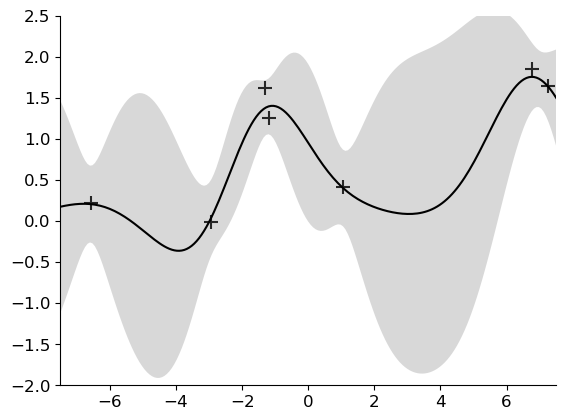

In [43]:
#using maximum sigma_y \ell to plot the gp figure 
#true_configs = [(12.58104604 ,0.61357821)]
true_configs = [(1.30959165,0.24012639)]
fig, ax = plt.subplots()
plot_gp_pred(x, y, xstar, k, sigma_f, *true_configs[0], ax)
pml.savefig("gpr_config0.pdf")